## EMPLOYEE ATTRITION PROJECT BASED ON ENSEMBLE LEARNING AND CUSTOM LOSS FUNCTION

### Importing Necessary Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import cudf
import cupy as cp
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import sklearn
import cuml
from sklearn.preprocessing import LabelEncoder
from cuml.model_selection import train_test_split
from cuml.linear_model import LogisticRegression
from cuml.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from cuml.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from cuml.metrics import confusion_matrix
import joblib

2025-03-16 22:13:17.880203: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-16 22:13:17.974486: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-16 22:13:18.000336: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-16 22:13:18.009543: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-16 22:13:18.146578: I tensorflow/core/platform/cpu_feature_guar

### Checking whether GPU is being used or not.

In [3]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1742143406.104652     482 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1742143406.110779     482 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1742143406.110884     482 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.


In [4]:
import tensorflow as tf
from tensorflow.python.client import device_lib
device_info = device_lib.list_local_devices()
for device in device_info:
    if device.device_type == "GPU":
        print(f"GPU Name: {device.physical_device_desc}")

GPU Name: device: 0, name: NVIDIA GeForce RTX 2050, pci bus id: 0000:02:00.0, compute capability: 8.6


I0000 00:00:1742143406.603162     482 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1742143406.603349     482 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1742143406.603402     482 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1742143407.018240     482 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1742143407.018418     482 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-16

### Importing the dataset and performing EDA

In [5]:
import cupy as cp
print(cp.cuda.runtime.getDeviceCount())  # Should return 1 or more

1


In [6]:
df = cudf.read_csv('Employee-Attrition.csv')

In [7]:
df

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,1,2061,...,3,80,1,17,3,3,5,2,0,3
1466,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,1,2062,...,1,80,1,9,5,3,7,7,1,7
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,...,2,80,1,6,0,3,6,2,0,3
1468,49,No,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,...,4,80,0,17,3,2,9,6,0,8


In [8]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [9]:
df.value_counts().sum()

1470

In [10]:
df.isnull().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

#### So there is no need of cleaning the null values. Thus, now checking for Target imbalance. 

In [11]:
df.Attrition.value_counts()

Attrition
No     1233
Yes     237
Name: count, dtype: int64

In [12]:
1233 / 237

5.2025316455696204

#### So to remove it we would be using Class Weights which would penalize for misclassifying the minority class, here it means the Yes Class.

#### Class Weights would be used during model development.

#### Now going on with further analysis

In [13]:
df.Department.value_counts()

Department
Research & Development    961
Sales                     446
Human Resources            63
Name: count, dtype: int64

In [14]:
df.JobRole.value_counts()

JobRole
Sales Executive              326
Research Scientist           292
Laboratory Technician        259
Manufacturing Director       145
Healthcare Representative    131
Manager                      102
Sales Representative          83
Research Director             80
Human Resources               52
Name: count, dtype: int64

In [15]:
df1 = df.copy()

In [16]:
df1['Department'] = df1['Department'].map({
    'Research & Development': 1,
    'Sales': 2,
    'Human Resources': 3
})

In [17]:
job_mapping = {
    'Sales Executive': 1,
    'Research Scientist': 2,
    'Laboratory Technician': 3,
    'Manufacturing Director': 4,
    'Healthcare Representative': 5,
    'Manager': 6,
    'Sales Representative': 7,
    'Research Director': 8,
    'Human Resources': 9
}

df1['JobRole'] = df1['JobRole'].map(job_mapping)

In [18]:
df1.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,2,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,1,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,1,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,1,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,1,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [19]:
print(df1.dtypes)

Age                          int64
Attrition                   object
BusinessTravel              object
DailyRate                    int64
Department                   int64
DistanceFromHome             int64
Education                    int64
EducationField              object
EmployeeCount                int64
EmployeeNumber               int64
EnvironmentSatisfaction      int64
Gender                      object
HourlyRate                   int64
JobInvolvement               int64
JobLevel                     int64
JobRole                      int64
JobSatisfaction              int64
MaritalStatus               object
MonthlyIncome                int64
MonthlyRate                  int64
NumCompaniesWorked           int64
Over18                      object
OverTime                    object
PercentSalaryHike            int64
PerformanceRating            int64
RelationshipSatisfaction     int64
StandardHours                int64
StockOptionLevel             int64
TotalWorkingYears   

In [20]:
encoder = LabelEncoder()
df1['BusinessTravel'] = encoder.fit_transform(df1['BusinessTravel'].to_numpy())
df1['EducationField'] = encoder.fit_transform(df1['EducationField'].to_numpy())
df1['Gender'] = encoder.fit_transform(df1['Gender'].to_numpy())
df1['MaritalStatus'] = encoder.fit_transform(df1['MaritalStatus'].to_numpy())
df1['Over18'] = encoder.fit_transform(df1['Over18'].to_numpy())
df1['OverTime'] = encoder.fit_transform(df1['OverTime'].to_numpy())

In [21]:
df1['Attrition'] = df1['Attrition'].map({
    'Yes': 1,
    'No': 0
})

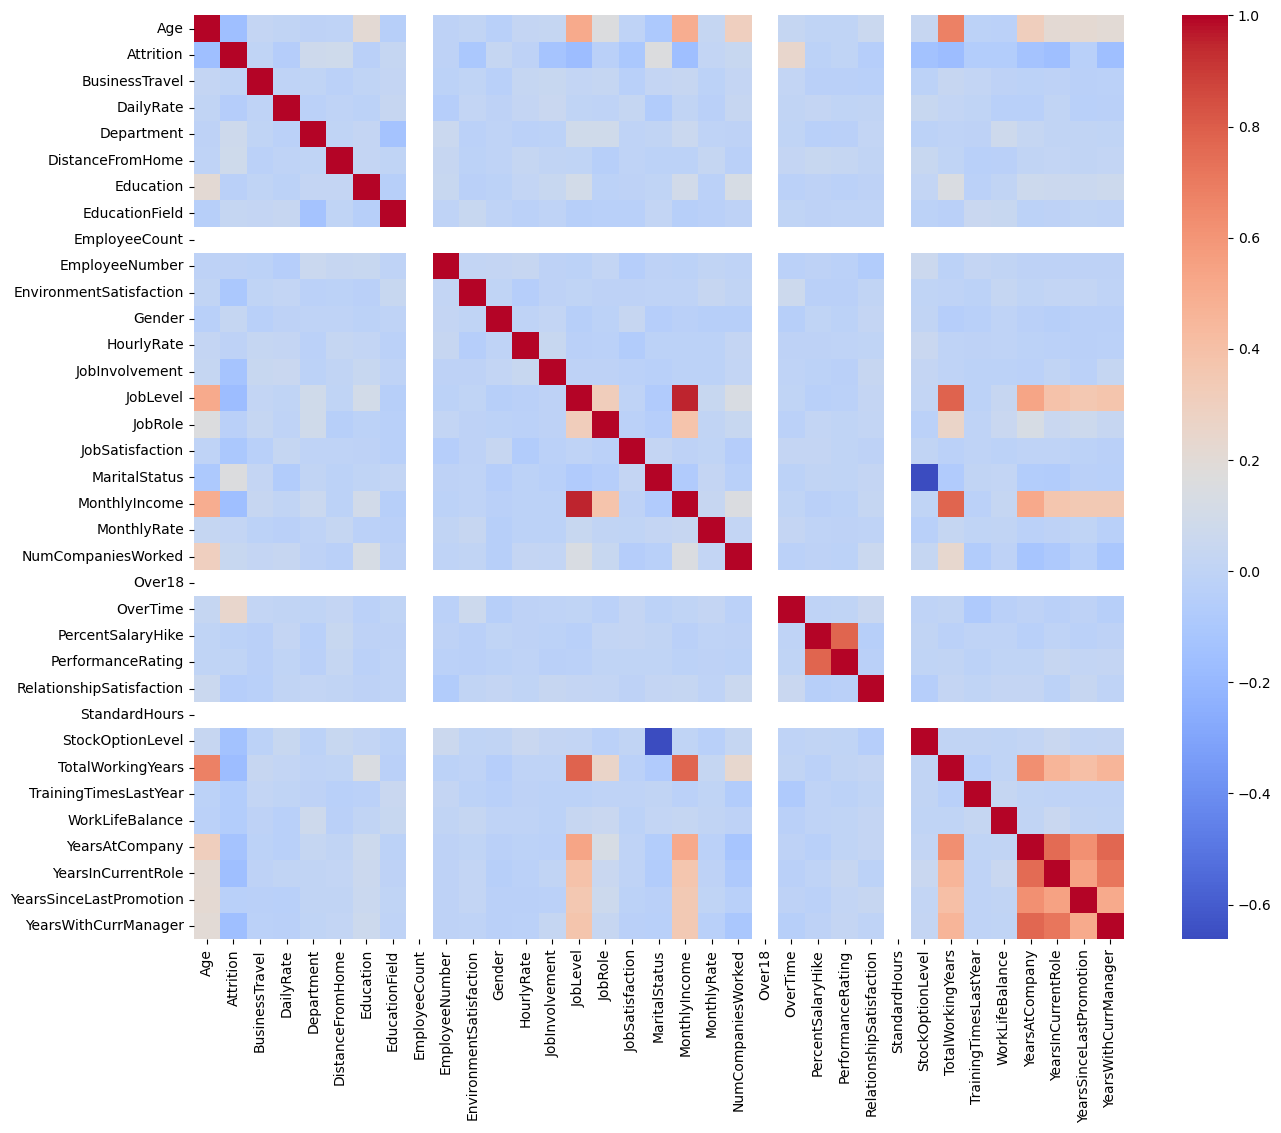

In [22]:
plt.figure(figsize=(15, 12)) 
sns.heatmap(df1.corr().to_numpy(), cmap='coolwarm', annot=False, xticklabels=df1.columns, yticklabels=df1.columns)
plt.xticks(rotation=90) 
plt.yticks(rotation=0) 
plt.show()

####
#### Age, Overtime, Job Level,Marital Status,Job Involvement, Monthly Income, Overtime, Total Working Years, Years at Company, Years in Current Role, Years with Current Manager. 
#### According to me, this are the important Variables which will decide the Output of our Model the lot.

#### 1. Boxplots for Numerical Variables (e.g., Age, MonthlyIncome, TotalWorkingYears, etc.)

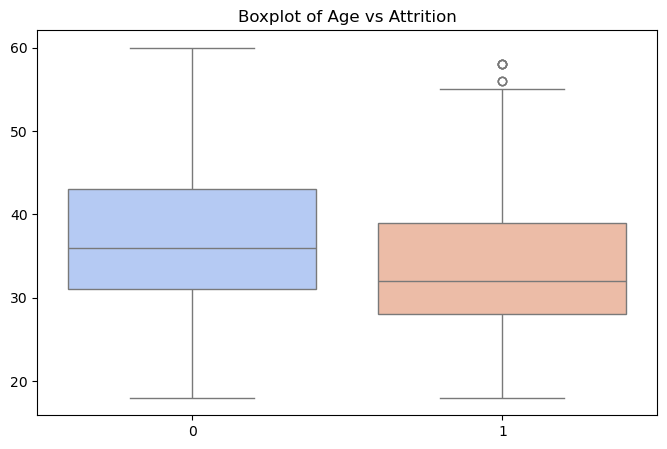

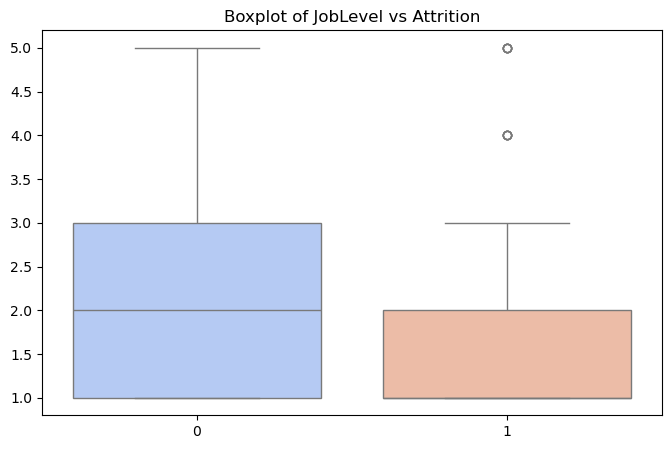

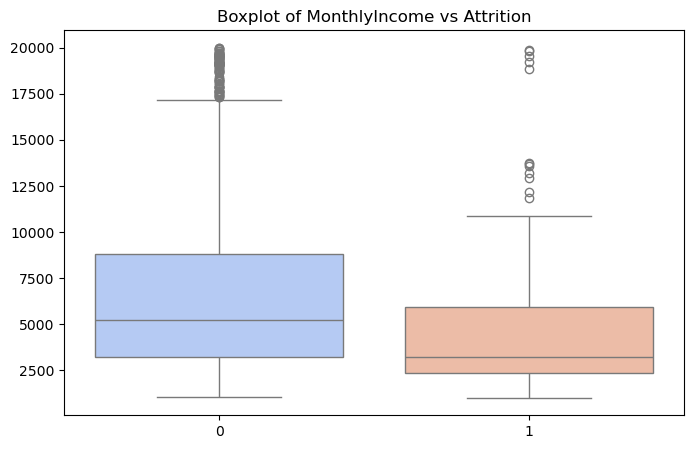

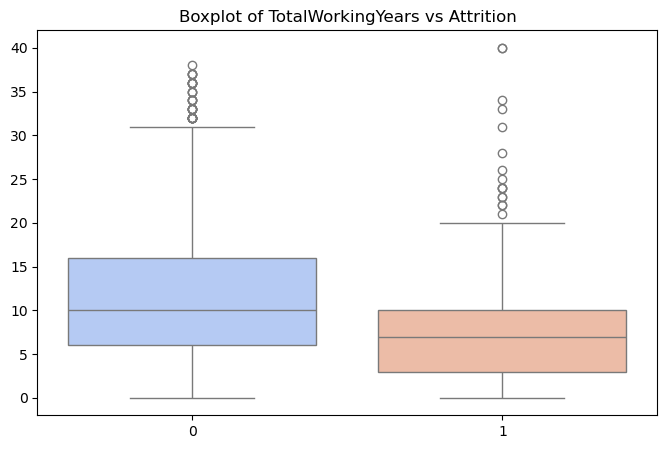

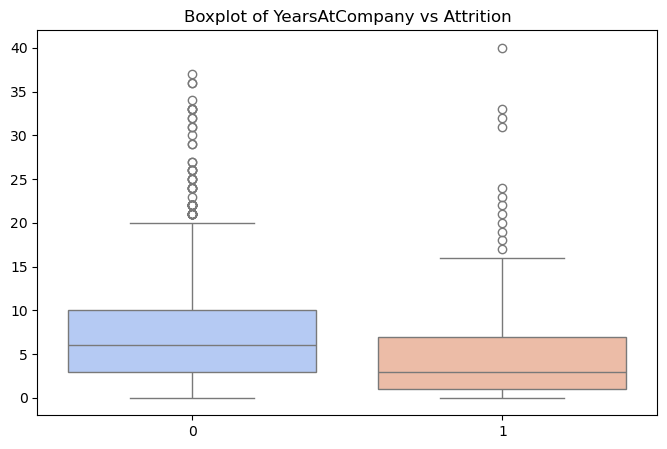

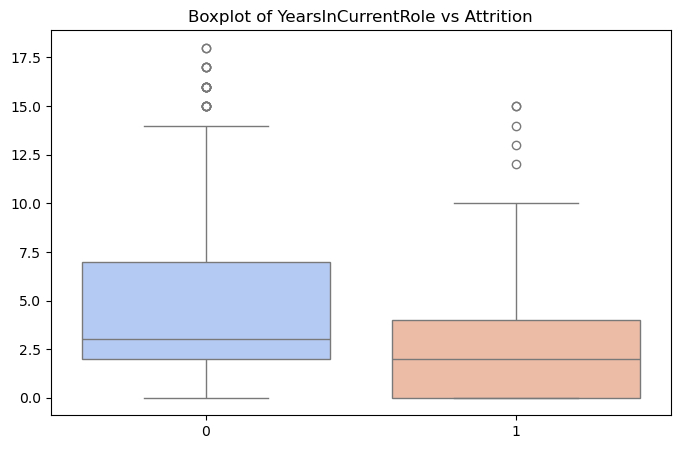

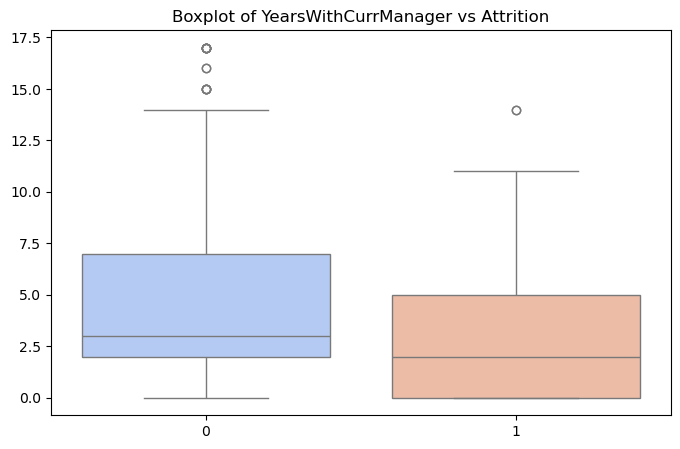

In [23]:
numerical_vars = ['Age', 'JobLevel', 'MonthlyIncome', 'TotalWorkingYears', 
                  'YearsAtCompany', 'YearsInCurrentRole', 'YearsWithCurrManager']

for var in numerical_vars:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=df1['Attrition'].to_numpy(), y=df1[var].to_numpy(), palette='coolwarm')
    plt.title(f'Boxplot of {var} vs Attrition')
    plt.show()

#### 2. Countplots for Categorical Variables (e.g., OverTime, MaritalStatus, JobInvolvement)

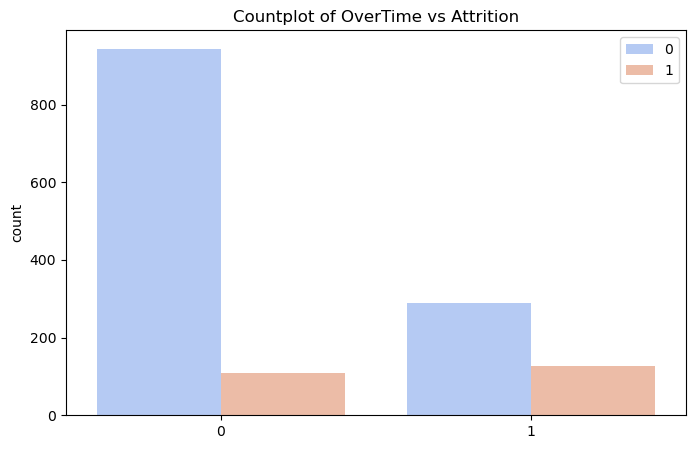

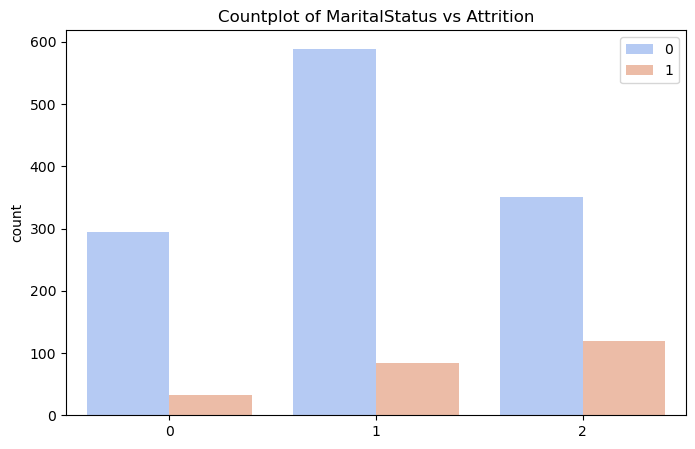

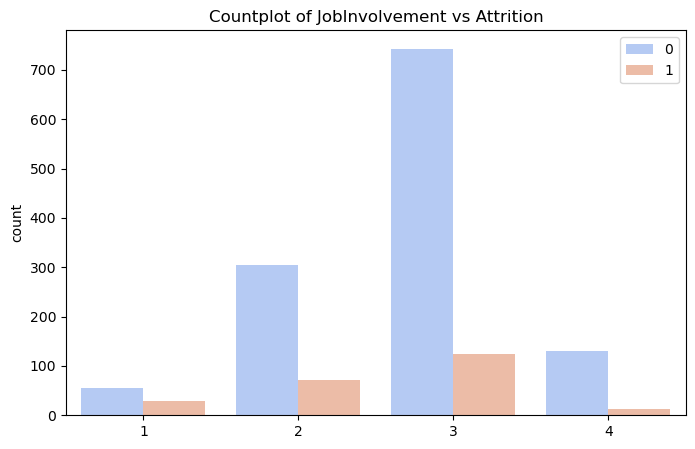

In [24]:
categorical_vars = ['OverTime', 'MaritalStatus', 'JobInvolvement']

for var in categorical_vars:
    plt.figure(figsize=(8, 5))
    sns.countplot(x=df1[var].to_numpy(), hue=df1['Attrition'].to_numpy(), palette='coolwarm')
    plt.title(f'Countplot of {var} vs Attrition')
    plt.show()

#### 3. Violin Plots for Distribution Comparison

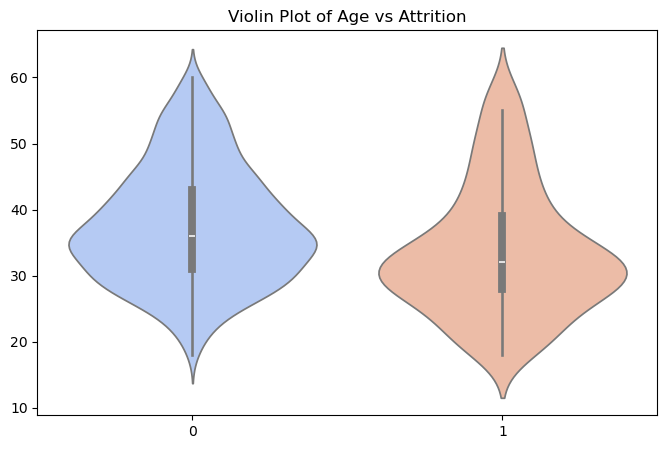

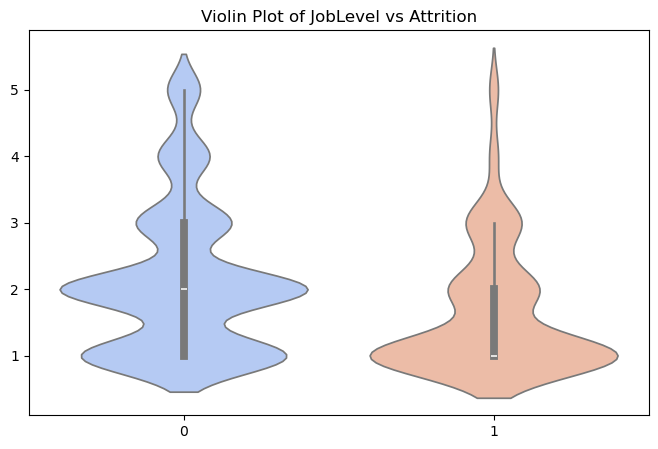

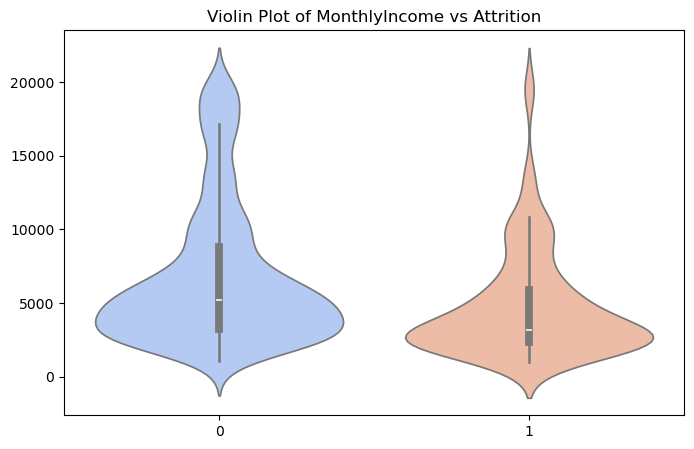

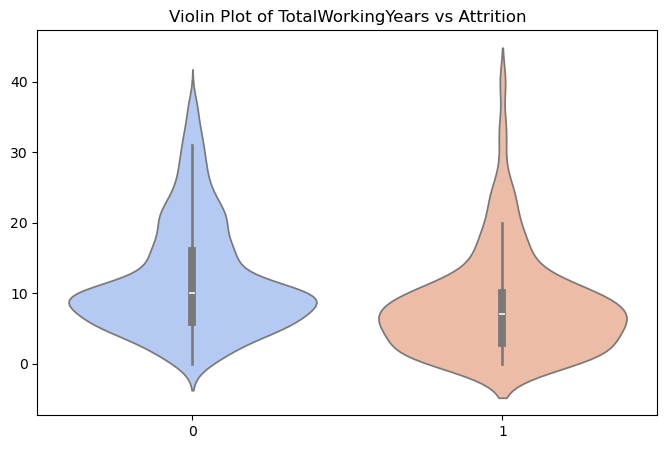

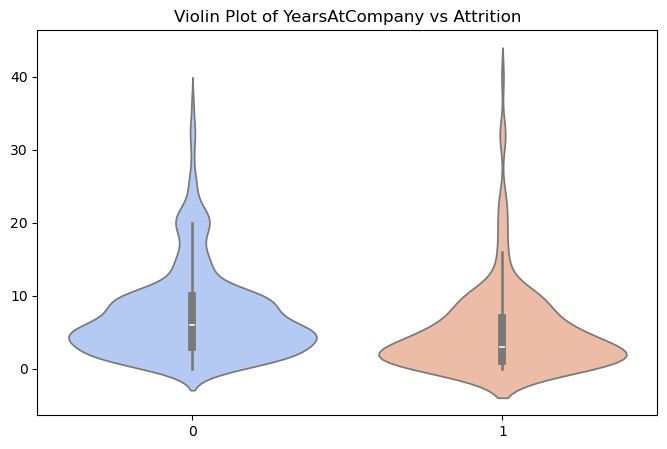

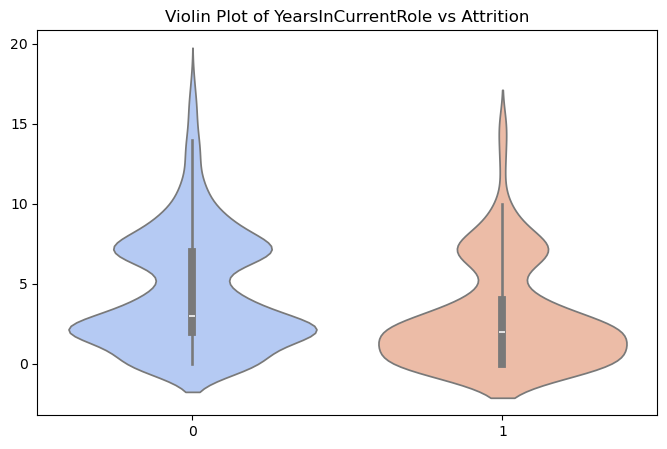

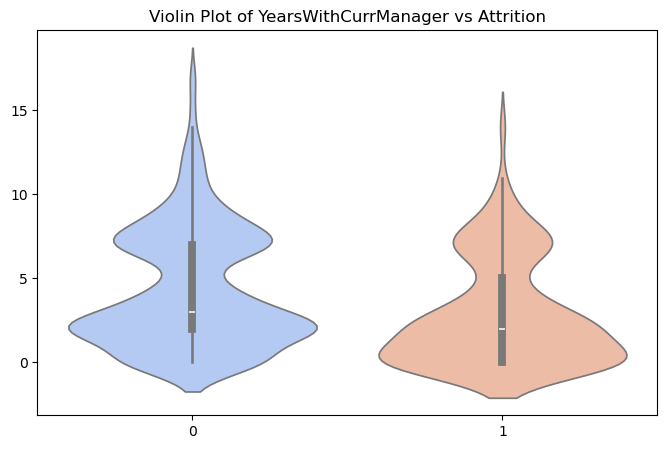

In [25]:
for var in numerical_vars:
    plt.figure(figsize=(8, 5))
    sns.violinplot(x=df1['Attrition'].to_numpy(), y=df1[var].to_numpy(), palette='coolwarm')
    plt.title(f'Violin Plot of {var} vs Attrition')
    plt.show()

#### 4. Bar Plots for Categorical Variables

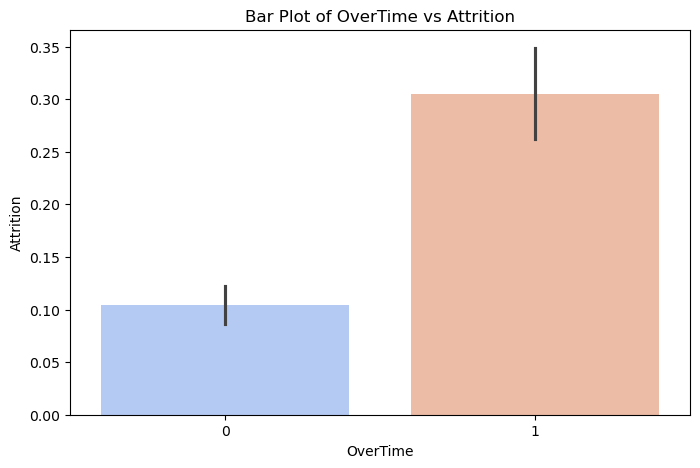

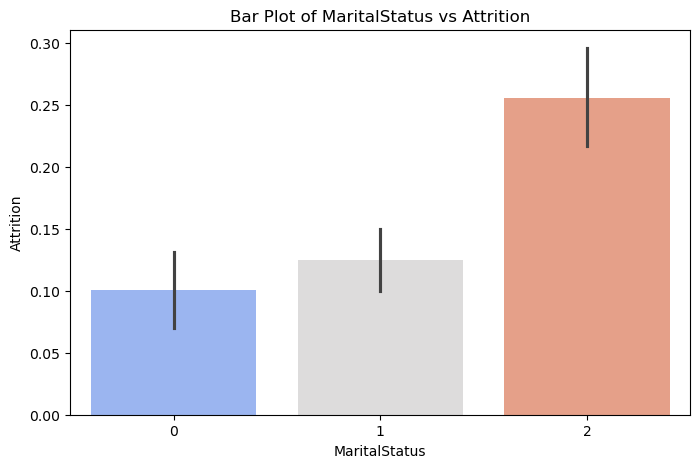

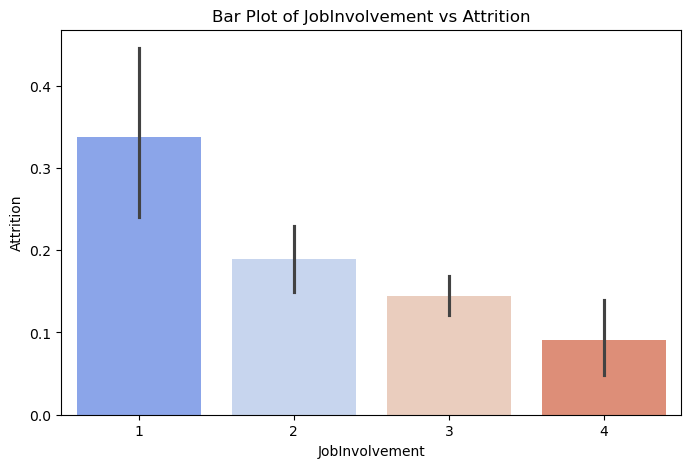

In [26]:
df2 = df1.copy()
df2['Attrition'] = df2['Attrition'].astype('category').cat.codes

for var in categorical_vars:
    plt.figure(figsize=(8, 5))
    sns.barplot(x=df2[var].to_pandas(), y=df2['Attrition'].to_pandas(), palette='coolwarm')
    plt.title(f'Bar Plot of {var} vs Attrition')
    plt.show()

In [27]:
df.MaritalStatus.value_counts()

MaritalStatus
Married     673
Single      470
Divorced    327
Name: count, dtype: int64

In [28]:
df.JobInvolvement.value_counts()

JobInvolvement
3    868
2    375
4    144
1     83
Name: count, dtype: int64

In [29]:
df1.PercentSalaryHike.value_counts()

PercentSalaryHike
11    210
13    209
14    201
12    198
15    101
18     89
17     82
16     78
19     76
22     56
20     55
21     48
23     28
24     21
25     18
Name: count, dtype: int64

### Starting with the model Development part. As we have converted the categorical data into numerical before no needed of doing it now. 
* First we will find out which variables/features we have to use.
* So, my threshold value would be 0.1 and -0.1.

In [30]:
corr_matrix = df1.corr()

In [31]:
attrition_corr = corr_matrix["Attrition"]
important_vars = attrition_corr[(attrition_corr > 0.1) | (attrition_corr < -0.1)].reset_index()

In [32]:
important_vars.columns = ["Feature", "Correlation"]

In [33]:
important_vars = important_vars.sort_values(by="Correlation", ascending=False)
print(important_vars)

                    Feature  Correlation
1                 Attrition     1.000000
8                  OverTime     0.246118
6             MaritalStatus     0.162070
2   EnvironmentSatisfaction    -0.103369
5           JobSatisfaction    -0.103481
3            JobInvolvement    -0.130016
11           YearsAtCompany    -0.134392
9          StockOptionLevel    -0.137145
13     YearsWithCurrManager    -0.156199
0                       Age    -0.159205
7             MonthlyIncome    -0.159840
12       YearsInCurrentRole    -0.160545
4                  JobLevel    -0.169105
10        TotalWorkingYears    -0.171063


#### Thus, we are only going to use the above variables/features only. This will help us to reduce the time complexity and Computational Complexity.

In [34]:
log_reg_params = [
    {'penalty': 'l2', 'tol': 1e-4, 'solver': 'qn', 'max_iter': 1000},
    {'penalty': 'l2', 'tol': 1e-3, 'solver': 'qn', 'max_iter': 2000},
    {'penalty': 'l2', 'tol': 1e-2, 'solver': 'qn', 'max_iter': 3000}
]

rf_params = [
    {'n_estimators': 50, 'max_depth': 5, 'min_samples_split': 2},
    {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 5},
    {'n_estimators': 200, 'max_depth': 100, 'min_samples_split': 2} 
]

In [35]:
log_models = [LogisticRegression(class_weight='balanced', **params) for params in log_reg_params]
rf_models = [RandomForestClassifier(random_state=42, **params) for params in rf_params]

In [36]:
ensemble = VotingClassifier(
    estimators=[
        ('log1', log_models[0]), ('log2', log_models[1]), ('log3', log_models[2]),
        ('rf1', rf_models[0]), ('rf2', rf_models[1]), ('rf3', rf_models[2])
    ],
    voting='soft'  
)

In [37]:
selected_features = important_vars["Feature"].to_pandas().to_list()
selected_features.remove("Attrition")

selected_features

['OverTime',
 'MaritalStatus',
 'EnvironmentSatisfaction',
 'JobSatisfaction',
 'JobInvolvement',
 'YearsAtCompany',
 'StockOptionLevel',
 'YearsWithCurrManager',
 'Age',
 'MonthlyIncome',
 'YearsInCurrentRole',
 'JobLevel',
 'TotalWorkingYears']

In [38]:
X = df1[selected_features]
y = df1['Attrition']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()
X_test_np = X_test.to_numpy()
y_test_np = y_test.to_numpy()

In [40]:
scaler = StandardScaler()
X_train_np = scaler.fit_transform(X_train_np)
X_test_np = scaler.transform(X_test_np)

In [41]:
ensemble.fit(X_train_np, y_train_np)

VotingClassifier(estimators=[('log1', LogisticRegression()),
                             ('log2', LogisticRegression()),
                             ('log3', LogisticRegression()),
                             ('rf1', RandomForestClassifier()),
                             ('rf2', RandomForestClassifier()),
                             ('rf3', RandomForestClassifier())],
                 voting='soft')

In [42]:
y_pred = ensemble.predict(X_test_np)

In [43]:
accuracy = accuracy_score(y_test_np, y_pred)
print("Voting Classifier Accuracy:", accuracy)

Voting Classifier Accuracy: 0.8605442047119141


### Now we are going to look at some of the Loss Functions which would tell us how correct our model is working

* 1]  Binary Cross-Entropy (BCE) Loss

In [44]:
def binary_cross_entropy_cupy(y_true, y_pred):
    y_pred = cp.clip(y_pred, 1e-7, 1 - 1e-7)  # Avoid log(0)
    return -cp.mean(y_true * cp.log(y_pred) + (1 - y_true) * cp.log(1 - y_pred))

y_true_cp = cp.array(y_test_np)  
y_pred_cp = cp.array(ensemble.predict_proba(X_test_np)[:, 1])

bce_loss = binary_cross_entropy_cupy(y_true_cp, y_pred_cp)
print("Binary Cross-Entropy Loss:", bce_loss)

Binary Cross-Entropy Loss: 0.40379790827190165


* 2] Gini Impurity 

In [45]:
def gini_impurity_cupy(y_pred):
    probs = cp.bincount(y_pred) / len(y_pred)  # Get probability of each class
    return 1 - cp.sum(probs ** 2)

y_pred_cp = cp.array(ensemble.predict(X_test_np)) 
gini = gini_impurity_cupy(y_pred_cp)
print("Gini Impurity:", gini)

Gini Impurity: 0.24001573418483058


* 3]  Entropy using Cupy

In [46]:
def entropy_loss_cupy(y_pred):
    probs = cp.bincount(y_pred) / len(y_pred)
    return -cp.sum(probs * cp.log2(probs + 1e-7))  # Avoid log(0)

entropy_val = entropy_loss_cupy(y_pred_cp)
print("Entropy (CuPy):", entropy_val)

Entropy (CuPy): 0.582811489674961


####  Custom Weighted Binary Cross-Entropy using CuPy

In [47]:
def weighted_binary_cross_entropy_cupy(y_true, y_pred, weight_for_1=2.0, weight_for_0=1.0):
    y_pred = cp.clip(y_pred, 1e-7, 1 - 1e-7)  # Avoid log(0)
    
    loss = -cp.mean(
        weight_for_1 * y_true * cp.log(y_pred) + 
        weight_for_0 * (1 - y_true) * cp.log(1 - y_pred)
    )
    
    return loss

weighted_bce_loss = weighted_binary_cross_entropy_cupy(y_true_cp, y_pred_cp)
print("Custom Weighted BCE Loss:", weighted_bce_loss)

Custom Weighted BCE Loss: 3.618348097862831


#### Trying with different perspectives

In [48]:
scaler = MinMaxScaler()
X_train_np = scaler.fit_transform(X_train_np)
X_test_np = scaler.transform(X_test_np)

In [49]:
joblib.dump(scaler, "minmax_scaler.pkl")

['minmax_scaler.pkl']

In [50]:
ensemble1 = VotingClassifier(
    estimators=[
        ('log1', log_models[0]), ('log2', log_models[1]), ('log3', log_models[2]),
        ('rf1', rf_models[0]), ('rf2', rf_models[1]), ('rf3', rf_models[2])
    ],
    voting='soft'  
)

In [51]:
ensemble1.fit(X_train_np, y_train_np)

VotingClassifier(estimators=[('log1', LogisticRegression()),
                             ('log2', LogisticRegression()),
                             ('log3', LogisticRegression()),
                             ('rf1', RandomForestClassifier()),
                             ('rf2', RandomForestClassifier()),
                             ('rf3', RandomForestClassifier())],
                 voting='soft')

In [52]:
y_pred = ensemble1.predict(X_test_np)

In [53]:
accuracy = accuracy_score(y_test_np, y_pred)
print("Voting Classifier Accuracy:", accuracy)

Voting Classifier Accuracy: 0.8639456033706665


In [54]:
def binary_cross_entropy_cupy(y_true, y_pred):
    y_pred = cp.clip(y_pred, 1e-7, 1 - 1e-7)  # Avoid log(0)
    return -cp.mean(y_true * cp.log(y_pred) + (1 - y_true) * cp.log(1 - y_pred))

y_true_cp = cp.array(y_test_np)  
y_pred_cp = cp.array(ensemble1.predict_proba(X_test_np)[:, 1])

bce_loss = binary_cross_entropy_cupy(y_true_cp, y_pred_cp)
print("Binary Cross-Entropy Loss:", bce_loss)

Binary Cross-Entropy Loss: 0.4089843899157778


In [55]:
def gini_impurity_cupy(y_pred):
    probs = cp.bincount(y_pred) / len(y_pred)  
    return 1 - cp.sum(probs ** 2)

y_pred_cp = cp.array(ensemble1.predict(X_test_np)) 
gini = gini_impurity_cupy(y_pred_cp)
print("Gini Impurity:", gini)

Gini Impurity: 0.2350872321717803


In [56]:
def entropy_loss_cupy(y_pred):
    probs = cp.bincount(y_pred) / len(y_pred)
    return -cp.sum(probs * cp.log2(probs + 1e-7))  # Avoid log(0)

entropy_val = entropy_loss_cupy(y_pred_cp)
print("Entropy (CuPy):", entropy_val)

Entropy (CuPy): 0.5738113956320279


In [57]:
def weighted_binary_cross_entropy_cupy(y_true, y_pred, weight_for_1=2.0, weight_for_0=1.0):
    y_pred = cp.clip(y_pred, 1e-7, 1 - 1e-7)  # Avoid log(0)
    
    loss = -cp.mean(
        weight_for_1 * y_true * cp.log(y_pred) + 
        weight_for_0 * (1 - y_true) * cp.log(1 - y_pred)
    )
    
    return loss

weighted_bce_loss = weighted_binary_cross_entropy_cupy(y_true_cp, y_pred_cp)
print("Custom Weighted BCE Loss:", weighted_bce_loss)

Custom Weighted BCE Loss: 3.5635246436060806


#### We will go with Ensemble1 Model due its high performance compared to Ensemble Model

#### Now seeing the predicted values against the true values

In [58]:
df_results = cudf.DataFrame({
    'True Values': y_test_np.flatten(),
    'Predicted Values': y_pred.flatten()
})

df_results.head()

,True Values,Predicted Values
0,0,0
1,0,0
2,0,0
3,0,0
4,0,1


In [59]:
df_results.tail()

,True Values,Predicted Values
289,1,0
290,0,0
291,1,0
292,0,0
293,0,0


In [60]:
# Converting to cupy array
y_true_cp = cp.asarray(y_test_np)
y_pred_cp = cp.asarray(y_pred)

In [61]:
cm = confusion_matrix(y_true_cp, y_pred_cp)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[229  15]
 [ 25  25]]


In [62]:
TN, FP, FN, TP = cm.ravel() 
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"True Positives (TP): {TP}")

True Negatives (TN): 229
False Positives (FP): 15
False Negatives (FN): 25
True Positives (TP): 25


In [63]:
TN, FP, FN, TP = cm.flatten()

In [64]:
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

Accuracy: 0.8639
Precision: 0.6250
Recall: 0.5000
F1 Score: 0.5556


### Now we will go with saving the model and then loading it back again:

In [65]:
joblib.dump(ensemble1, "model.pkl")
print("Model saved successfully!")

Model saved successfully!


In [66]:
loaded_model = joblib.load("model.pkl")
print("Model loaded successfully!")

Model loaded successfully!


### Now the final step of taking inputs from the user and then predicting the output

In [67]:
feature_names = [
    "OverTime", "MaritalStatus", "EnvironmentSatisfaction", "JobSatisfaction",
    "JobInvolvement", "YearsAtCompany", "StockOptionLevel", "MonthlyIncome",
    "YearsWithCurrManager", "Age", "YearsInCurrentRole", "JobLevel", "TotalWorkingYears"
]

for i in feature_names:
    print(f"The values in {i} are: {df1[i].value_counts()}")

The values in OverTime are: OverTime
0    1054
1     416
Name: count, dtype: int64
The values in MaritalStatus are: MaritalStatus
1    673
2    470
0    327
Name: count, dtype: int64
The values in EnvironmentSatisfaction are: EnvironmentSatisfaction
3    453
4    446
2    287
1    284
Name: count, dtype: int64
The values in JobSatisfaction are: JobSatisfaction
4    459
3    442
1    289
2    280
Name: count, dtype: int64
The values in JobInvolvement are: JobInvolvement
3    868
2    375
4    144
1     83
Name: count, dtype: int64
The values in YearsAtCompany are: YearsAtCompany
5     196
1     171
3     128
2     127
10    120
4     110
7      90
9      82
8      80
6      76
0      44
11     32
20     27
13     24
15     20
14     18
22     15
12     14
21     14
18     13
16     12
19     11
17      9
24      6
33      5
26      4
25      4
32      3
31      3
36      2
23      2
27      2
29      2
40      1
37      1
30      1
34      1
Name: count, dtype: int64
The values in Stock

In [68]:
categorical_features = ["OverTime", "MaritalStatus"]

label_encoders = {}

for feature in categorical_features:
    encoder = LabelEncoder()
    encoder.fit(df[feature].to_numpy())  
    label_encoders[feature] = encoder
    print(f"\nLabel Encoding Mapping for {feature}:")
    for i, class_label in enumerate(encoder.classes_):
        print(f"{i} - {class_label}")


Label Encoding Mapping for OverTime:
0 - No
1 - Yes

Label Encoding Mapping for MaritalStatus:
0 - Divorced
1 - Married
2 - Single


In [70]:
# We can save df1 to a csv inorder to use it for upcoming prediction
df1.to_csv(r'Copied_Dataset.csv')

In [71]:
a = int(input("Enter value for Overtime [0 for No and 1 for Yes]: "))
b = int(input("Enter value for Marital Status [0 for Divorced, 1 for Married and 2 for Single]: "))
c = int(input("Enter Environment Satisfaction Level [1:'Low', 2:'Medium', 3:'High', 4:'Very High']: "))
d = int(input("Enter Job Satisfaction Level [1:'Low', 2:'Medium', 3:'High', 4:'Very High']: "))
e = int(input("Enter Job Involvement Level [1:'Low', 2:'Medium', 3:'High', 4:'Very High']: "))
f = int(input("Enter Years of Working in the Company: "))
g = int(input("Enter Stock Option Level of the Employee: "))
h = int(input("Enter Monthly Income of the Employee: "))
i = int(input("Enter Years of the Employee with the Current Manager: "))
j = int(input("Enter Age of the Employee: "))
k = int(input("Enter Years of the Employee in the Current Role: "))
l = int(input("Enter Job Level of the Employee: "))
m = int(input("Enter Total Working Years of the Employee: "))

Enter value for Overtime [0 for No and 1 for Yes]:  1
Enter value for Marital Status [0 for Divorced, 1 for Married and 2 for Single]:  2
Enter Environment Satisfaction Level [1:'Low', 2:'Medium', 3:'High', 4:'Very High']:  2
Enter Job Satisfaction Level [1:'Low', 2:'Medium', 3:'High', 4:'Very High']:  4
Enter Job Involvement Level [1:'Low', 2:'Medium', 3:'High', 4:'Very High']:  3
Enter Years of Working in the Company:  6
Enter Stock Option Level of the Employee:  0
Enter Monthly Income of the Employee:  5993
Enter Years of the Employee with the Current Manager:  5
Enter Age of the Employee:  41
Enter Years of the Employee in the Current Role:  4
Enter Job Level of the Employee:  2
Enter Total Working Years of the Employee:  8


In [72]:
user_data = np.array([
    a,  # OverTime
    b,  # MaritalStatus
    c,  # EnvironmentSatisfaction
    d,  # JobSatisfaction
    e,  # JobInvolvement
    f,  # YearsAtCompany
    g,  # StockOptionLevel
    i,  # YearsWithCurrManager
    j,  # Age
    h,  # MonthlyIncome
    k,  # YearsInCurrentRole
    l,  # JobLevel
    m   # TotalWorkingYears
])

In [73]:
user_data = user_data.reshape(1, -1)
print("Final input array shape:", user_data.shape)

Final input array shape: (1, 13)


In [74]:
scaler = joblib.load("minmax_scaler.pkl")

#### We have loaded the model beforehand so no need of loading it again.

In [75]:
user_data_scaled = scaler.transform(user_data)

In [76]:
prediction = loaded_model.predict(user_data_scaled)
print("Model Prediction:", prediction)

Model Prediction: [0]
